In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#photo = cv2.imread('sample-photos/old_photo_16.jpg')
photo = cv2.imread('sample-photos/old_photo_23.jpg')

In [ ]:
def show_image(title, img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 4))
    plt.title(title)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

MASKING AND INPAINT 

In [ ]:
#function to check if the image has scratches or damages that need inpainting
def needs_masking(photo):
    #convert to greyscale 
    grey = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY) 
    #create mask of pixels with brightness in between 110 and 160
    mask_mid = cv2.inRange(grey, 110, 160) 

    #calculate if mask contains damage
    damage_ratio = np.count_nonzero(mask_mid) / mask_mid.size
    
    #if more than 1% damage return true 
    return damage_ratio > 0.01   

In [ ]:
#function to generate a mask and repaint those areas 
def masking(photo):
    #convert to greyscale
    grey = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    #select mid-intensity pixels where scratches appear
    mask_mid = cv2.inRange(grey, 110, 160) 
    #create a kernel for morphological filtering
    kernel = np.ones((5,5), np.uint8)
    
    #opening to remove small isolated noise 
    mask_mid = cv2.morphologyEx(mask_mid, cv2.MORPH_OPEN, kernel)
    #closing to fill tiny hiles detected 
    mask_mid = cv2.morphologyEx(mask_mid, cv2.MORPH_CLOSE, kernel)

    #another opening to remove bigger spots(reduce false positives)
    mask_small = cv2.morphologyEx(mask_mid, cv2.MORPH_OPEN, np.ones((9,9), np.uint8))
    #conevet into binary mask
    _, damage_mask = cv2.threshold(mask_small, 127, 255, cv2.THRESH_BINARY)

    #use inpaint to fill in the damaged areas 
    restored = cv2.inpaint(photo, damage_mask, 5, cv2.INPAINT_TELEA)

    return damage_mask, restored
show_image("Original Photo", photo)
show_image("inpaint", masking(photo)[1])


GAUSSIAN 

In [ ]:
#function to check if the images are noisy enough to need gaussian blur
def needs_gaussian(photo, threshold=300): 
    #convert to greyscale
    grey = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY) 
    #apply laplacian  to highlight edges and noise 
    lap = cv2.Laplacian(grey, cv2.CV_64F)
    #calcuate variance of the laplacian  
    noise_level = lap.var() 
    
    #if noise is abouve threshold return true 
    return noise_level > threshold

In [ ]:
#function to apply the gaussian blur
def gaussian(photo, ksize=3, sigma=0.5): 
    return cv2.GaussianBlur(photo, (ksize, ksize), sigma) 

show_image("Original Photo", photo) 
show_image("Gaussian Blurred", gaussian(photo))

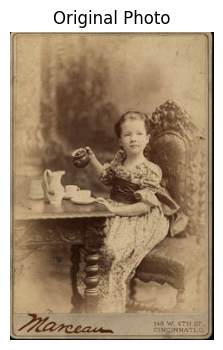

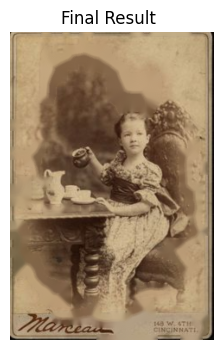

In [182]:
def iria(photo):
    output = photo.copy()

    #check for noise
    if needs_gaussian(output):
        output = gaussian(output)

    #check for damage
    #should apply sharpening after inpainting
    if needs_masking(output):
        mask, output = masking(output)

    return output
result = iria(photo)
show_image("Original Photo", photo)
show_image("Final Result ", result)
